In [9]:
import pickle
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import yfinance as yf

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

In [10]:
#### Input params ##################
ticker = "LULU"
period = '3y'
interval = '1d'

test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [11]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est, model


In [12]:
#tock = yf.Ticker(ticker)
#f = stock.history(period="2y", interval='1d').drop(columns=["Dividends", "Stock Splits"])
df = yf.download(ticker, period=period, interval=interval)

df.reset_index(inplace=True)
df.rename(columns={"index": "Date"}, inplace=True)

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,adj_close,volume,month
0,2019-07-01,182.330002,183.830002,179.309998,179.949997,179.949997,1813300,7
1,2019-07-02,179.949997,182.699997,179.589996,180.860001,180.860001,1859500,7
2,2019-07-03,181.509995,184.470001,180.800003,183.990005,183.990005,1178800,7
3,2019-07-05,183.199997,183.460007,180.699997,183.210007,183.210007,1511700,7
4,2019-07-08,181.860001,186.949997,181.600006,186.800003,186.800003,1882900,7


Text(0, 0.5, 'USD')

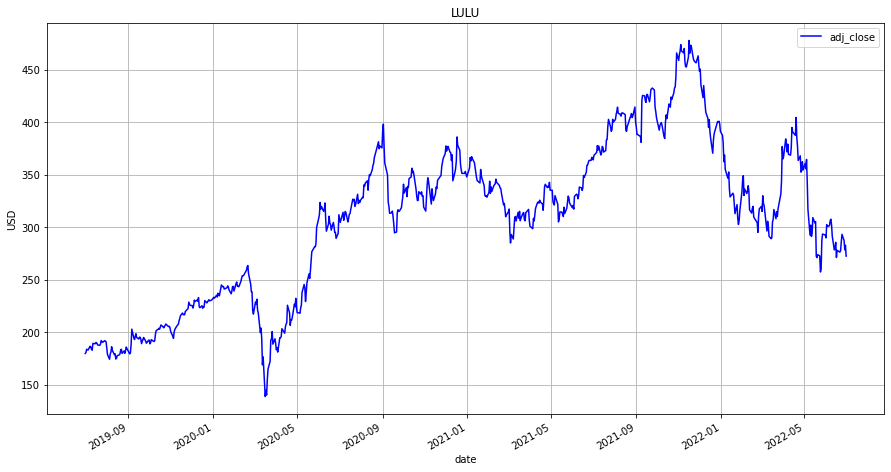

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True, title=ticker)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [14]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(columns=['high', 'low'], inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(columns=['open', 'close'], inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2019-07-01,179.949997,1813300,7,4.520004,2.380005
1,2019-07-02,180.860001,1859500,7,3.110001,-0.910004
2,2019-07-03,183.990005,1178800,7,3.669998,-2.480011
3,2019-07-05,183.210007,1511700,7,2.760010,-0.010010
4,2019-07-08,186.800003,1882900,7,5.349991,-4.940002


In [15]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = df.index
df.head()


,date,adj_close,volume,month,range_hl,range_oc,order_day
0,2019-07-01,179.949997,1813300,7,4.520004,2.380005,0
1,2019-07-02,180.860001,1859500,7,3.110001,-0.910004,1
2,2019-07-03,183.990005,1178800,7,3.669998,-2.480011,2
3,2019-07-05,183.210007,1511700,7,2.760010,-0.010010,3
4,2019-07-08,186.800003,1882900,7,5.349991,-4.940002,4


In [16]:
# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [17]:
shift_range = [x+1 for x in range(N)]

for shift in shift_range:
    train_shift = df[merging_keys + lag_cols].copy()

    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)

del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]

df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2019-07-05,183.210007,1511700,7,2.760010,-0.010010,3,183.990005,3.669998,-2.480011,1178800.0,180.860001,3.110001,-0.910004,1859500.0,179.949997,4.520004,2.380005,1813300.0
4,2019-07-08,186.800003,1882900,7,5.349991,-4.940002,4,183.210007,2.760010,-0.010010,1511700.0,183.990005,3.669998,-2.480011,1178800.0,180.860001,3.110001,-0.910004,1859500.0
5,2019-07-09,186.050003,2323100,7,2.600006,-1.120010,5,186.800003,5.349991,-4.940002,1882900.0,183.210007,2.760010,-0.010010,1511700.0,183.990005,3.669998,-2.480011,1178800.0
6,2019-07-10,183.869995,1467000,7,4.160004,3.130005,6,186.050003,2.600006,-1.120010,2323100.0,186.800003,5.349991,-4.940002,1882900.0,183.210007,2.760010,-0.010010,1511700.0
7,2019-07-11,183.070007,1244600,7,2.809998,0.639999,7,183.869995,4.160004,3.130005,1467000.0,186.050003,2.600006,-1.120010,2323100.0,186.800003,5.349991,-4.940002,1882900.0


In [18]:
cols_list = [
    "adj_close",
    "range_hl",
    "range_oc",
    "volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2019-07-05,183.210007,1511700,7,2.760010,-0.010010,3,183.990005,3.669998,-2.480011,...,2.380005,1813300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-08,186.800003,1882900,7,5.349991,-4.940002,4,183.210007,2.760010,-0.010010,...,-0.910004,1859500.0,183.210007,NaN,2.760010,NaN,-0.010010,NaN,1511700.0,NaN
5,2019-07-09,186.050003,2323100,7,2.600006,-1.120010,5,186.800003,5.349991,-4.940002,...,-2.480011,1178800.0,185.005005,2.538511,4.055000,1.831393,-2.475006,3.486031,1697300.0,262478.037176
6,2019-07-10,183.869995,1467000,7,4.160004,3.130005,6,186.050003,2.600006,-1.120010,...,-0.010010,1511700.0,185.353338,1.893680,3.570002,1.543590,-2.023341,2.586158,1905900.0,406188.675371
7,2019-07-11,183.070007,1244600,7,2.809998,0.639999,7,183.869995,4.160004,3.130005,...,-4.940002,1882900.0,185.573334,1.522053,4.036667,1.379135,-0.976669,4.036913,1891000.0,428107.474824


In [19]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))
print()

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 454
num_cv = 150
num_test = 150

train.shape = (454, 27)
cv.shape = (150, 27)
train_cv.shape = (604, 27)
test.shape = (150, 27)


In [20]:
cols_to_scale = [
    "adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))
print()

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 2.71842864e+02  2.71501983e+02  8.37704854e+00 -3.69384026e-02
  1.79773943e+06  2.71180793e+02  8.36191643e+00 -1.74009684e-02
  1.79909559e+06  2.70880485e+02  8.35244506e+00 -2.64978283e-02
  1.80117731e+06]
scaler.var_ = [4.27858599e+03 4.28560979e+03 2.24311952e+01 3.05803766e+01
 1.32108537e+12 4.29689728e+03 2.24864120e+01 3.03725830e+01
 1.32041606e+12 4.31065779e+03 2.25183717e+01 3.02913128e+01
 1.31850343e+12]
train_scaled.shape = (454, 13)

train_scaled.shape = (454, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.355017,-1.336784,-0.993854,-0.441789,-0.538496,-1.377876,-1.107536,-0.161964,0.052567,-1.384962,-0.807620,0.437247,0.010557,2019-07-05,7
1,-1.300133,-1.348699,-1.185991,0.004870,-0.248863,-1.330127,-0.989442,-0.446843,-0.539813,-1.371101,-1.104753,-0.160528,0.050792,2019-07-08,7
2,-1.311599,-1.293860,-0.639138,-0.886638,0.074092,-1.342026,-1.181342,0.001341,-0.250106,-1.323428,-0.986744,-0.445789,-0.542017,2019-07-09,7
3,-1.344927,-1.305316,-1.219774,-0.195856,0.457080,-1.287259,-0.635161,-0.893210,0.072931,-1.335308,-1.178508,0.002996,-0.252101,2019-07-10,7
4,-1.357157,-1.338617,-0.890394,0.572689,-0.287753,-1.298701,-1.215084,-0.200069,0.456015,-1.280629,-0.632715,-0.892755,0.071171,2019-07-11,7


In [21]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
print()

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 3.00660580e+02  3.00205662e+02  8.49334457e+00 -5.20200666e-02
  1.58838675e+06  2.99741970e+02  8.47339423e+00 -7.42220594e-02
  1.59014785e+06  2.99256788e+02  8.46566244e+00 -7.25167634e-02
  1.59170579e+06]
scaler_train_cv.var_ = [6.24696067e+03 6.22790702e+03 1.99319799e+01 3.21385828e+01
 1.24643478e+12 6.20850505e+03 1.99059794e+01 3.18784590e+01
 1.24551332e+12 6.18232887e+03 1.99309457e+01 3.18850700e+01
 1.24474018e+12]
train_cv_scaled.shape = (604, 13)

train_cv_scaled.shape = (604, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.486007,-1.472630,-1.080372,-0.428286,-0.366869,-1.508768,-1.202120,-0.148028,0.241349,-1.517362,-0.883803,0.434329,0.198618,2019-07-05,7
1,-1.440585,-1.482514,-1.284198,0.007410,-0.068689,-1.469044,-1.076606,-0.426097,-0.368583,-1.505788,-1.199635,-0.148315,0.240028,2019-07-08,7
2,-1.450074,-1.437023,-0.704074,-0.862216,0.263797,-1.478943,-1.280565,0.011373,-0.070292,-1.465980,-1.074199,-0.426355,-0.370094,2019-07-09,7
3,-1.477656,-1.446526,-1.320037,-0.188388,0.658087,-1.433382,-0.700062,-0.861795,0.262317,-1.475900,-1.278031,0.011070,-0.071710,2019-07-10,7
4,-1.487778,-1.474151,-0.970616,0.561294,-0.108727,-1.442900,-1.316427,-0.185223,0.656752,-1.430242,-0.697891,-0.862007,0.261002,2019-07-11,7


In [22]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in cols_list:
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)

# Now the entire dev set is scaled
cv_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
457,2021-04-23,1.023979,-0.049821,-0.974158,1.104652,-0.261108,-0.843544,-0.707404,-0.436668,1.144072,1.106540,-0.267479,-0.839061
458,2021-04-26,0.716181,0.426328,-1.142510,-1.064081,0.920368,0.143713,1.113535,-0.821399,-0.292135,-0.079334,1.037304,-0.957970
459,2021-04-27,-0.843356,1.104732,-0.261377,-0.507496,-0.644493,1.151988,0.875787,0.213833,-1.089620,-1.073809,0.169209,0.904600
460,2021-04-28,-0.046085,-0.976161,1.022246,-0.979413,1.019388,-0.039974,-0.366168,1.131472,-0.765305,-0.725043,-0.415768,1.140811
461,2021-04-29,-0.404960,1.138966,-0.734006,0.679281,-1.148302,0.469021,0.143935,-1.064168,0.920233,-0.532880,-0.620706,1.153587


In [23]:
# Do scaling for test set
test_scaled = test[['date']]
for col in cols_list:
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
607,2021-11-24,-0.712967,-0.430128,1.143096,-0.334533,1.124380,-0.789847,-0.528855,1.153379,-0.624523,-1.110976,0.282911,0.828066
608,2021-11-26,-0.838528,-0.268234,1.106762,-0.303908,-0.812790,1.116697,-0.934160,-0.120719,1.054880,-0.410894,-0.729098,1.139992
609,2021-11-29,-1.052782,0.115615,0.937167,-1.079654,0.894455,0.185199,0.741838,-1.137246,0.395409,-1.142662,0.715353,0.427309
610,2021-11-30,1.135732,-0.748379,-0.387353,0.403897,-1.138778,0.734882,-0.517417,1.152694,-0.635277,0.902081,-1.075290,0.173209
611,2021-12-01,-0.796376,1.122301,-0.325925,1.088461,-0.210405,-0.878056,0.913354,-1.068509,0.155154,1.058909,-0.130664,-0.928245


In [24]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]

X_cv = cv[features]
y_cv = cv[target]

X_train_cv = train_cv[features]
y_train_cv = train_cv[target]

X_sample = test[features]
y_sample = test[target]

print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (454, 12)
y_train.shape = (454,)
X_cv.shape = (150, 12)
y_cv.shape = (150,)
X_train_cv.shape = (604, 12)
y_train_cv.shape = (604,)
X_sample.shape = (150, 12)
y_sample.shape = (150,)


In [25]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]

X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]

y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]

print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (454, 12)
y_train_scaled.shape = (454,)
X_cv_scaled.shape = (150, 12)
X_train_cv_scaled.shape = (604, 12)
y_train_cv_scaled.shape = (604,)
X_sample_scaled.shape = (150, 12)


In [28]:
model = pickle.load(open("xgboostModel.pkl", 'rb'))

In [29]:
est_scaled = model.predict(X_sample_scaled)
est = est_scaled * test['adj_close_mean'] + test['adj_close_std']

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 15, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 11, 15), date(2022, 7, 15)])
ax.set_ylim([250, 500])